In [2]:
import tqdm
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rcParams.update({"font.size": 10})
import torch

In [3]:
import sys
sys.path.append("../src/")

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import layers
import updates
import utils

In [4]:
ranks = np.round(np.logspace(start=np.log10(1), stop=np.log10(10_000), num=21)).astype(int)
" ".join(map(str, ranks[7:]))

'25 40 63 100 158 251 398 631 1000 1585 2512 3981 6310 10000'

In [23]:
experiments_path = "/cluster/home/eharve06/overfitting-ELBO/experiments/sin_dataset/diag_epochs=1000_N=20_num_samples=10_seed=2.pth"
diag_data = torch.load(experiments_path, map_location=torch.device("cpu"), weights_only=False)


In [24]:
experiments_path = "/cluster/home/eharve06/overfitting-ELBO/experiments/sin_dataset/rank1_epochs=1000_N=20_num_samples=10_seed=2.pth"
rank1_data = torch.load(experiments_path, map_location=torch.device("cpu"), weights_only=False)


In [25]:
experiments_path = "/cluster/home/eharve06/overfitting-ELBO/experiments/sin_dataset/fullrank_epochs=1000_N=20_num_samples=10_seed=2.pth"
fullrank_data = torch.load(experiments_path, map_location=torch.device("cpu"), weights_only=False)


In [26]:
num_ranks, num_samples, num_lrs, num_epochs = rank1_data["elbos"].shape
values, indices = rank1_data["elbos"].view(num_ranks, num_samples, num_lrs * num_epochs).max(dim=2, keepdim=True)
rank1_elbos = rank1_data["elbos"].view(num_ranks, num_samples, num_lrs * num_epochs).gather(2, indices).squeeze()
rank1_lmls = rank1_data["lmls"].view(num_ranks, num_samples, num_lrs * num_epochs).gather(2, indices).squeeze()


In [27]:
num_ranks, num_samples, num_lrs, num_epochs = diag_data["elbos"].shape
values, indices = diag_data["elbos"].view(num_ranks, num_samples, num_lrs * num_epochs).max(dim=2, keepdim=True)
diag_elbos = diag_data["elbos"].view(num_ranks, num_samples, num_lrs * num_epochs).gather(2, indices).squeeze()
diag_lmls = diag_data["lmls"].view(num_ranks, num_samples, num_lrs * num_epochs).gather(2, indices).squeeze()


In [28]:
num_ranks, num_samples, num_lrs, num_epochs = fullrank_data["elbos"].shape
values, indices = fullrank_data["elbos"].view(num_ranks, num_samples, num_lrs * num_epochs).max(dim=2, keepdim=True)
fullrank_elbos = fullrank_data["elbos"].view(num_ranks, num_samples, num_lrs * num_epochs).gather(2, indices).squeeze()
fullrank_lmls = fullrank_data["lmls"].view(num_ranks, num_samples, num_lrs * num_epochs).gather(2, indices).squeeze()


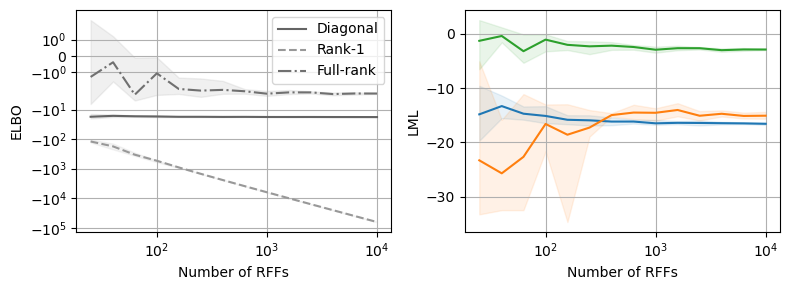

In [30]:
ncols, nrows = 2, 1
fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), ncols=ncols, nrows=nrows)

grayscale_blue = sum(w*c for w, c in zip((0.299, 0.587, 0.114), mcolors.to_rgb("#1F77B4")))
grayscale_orange = sum(w*c for w, c in zip((0.299, 0.587, 0.114), mcolors.to_rgb("#FF7F0E")))
grayscale_green = sum(w*c for w, c in zip((0.299, 0.587, 0.114), mcolors.to_rgb("#2CA02C")))

axs[0].plot(diag_data["ranks"], diag_elbos.mean(dim=1), color=(grayscale_blue, grayscale_blue, grayscale_blue), label="Diagonal", linestyle="-")
axs[0].fill_between(diag_data["ranks"], torch.quantile(diag_elbos, q=0.1, dim=1), torch.quantile(diag_elbos, q=0.9, dim=1), alpha=0.1, color=(grayscale_blue, grayscale_blue, grayscale_blue))
axs[0].plot(rank1_data["ranks"], rank1_elbos.mean(dim=1), color=(grayscale_orange, grayscale_orange, grayscale_orange), label="Rank-1", linestyle="--")
axs[0].fill_between(rank1_data["ranks"], torch.quantile(rank1_elbos, q=0.1, dim=1), torch.quantile(rank1_elbos, q=0.9, dim=1), alpha=0.1, color=(grayscale_orange, grayscale_orange, grayscale_orange))
axs[0].plot(fullrank_data["ranks"], fullrank_elbos.mean(dim=1), color=(grayscale_green, grayscale_green, grayscale_green), label="Full-rank", linestyle="-.")
axs[0].fill_between(fullrank_data["ranks"], torch.quantile(fullrank_elbos, q=0.1, dim=1), torch.quantile(fullrank_elbos, q=0.9, dim=1), alpha=0.1, color=(grayscale_green, grayscale_green, grayscale_green))
axs[0].set_xlabel("Number of RFFs")
axs[0].set_ylabel("ELBO")
axs[0].set_xscale("symlog")
axs[0].set_yscale("symlog")
axs[0].legend()
axs[0].grid()

axs[1].plot(diag_data["ranks"], diag_lmls.mean(dim=1), color="#1F77B4")
axs[1].fill_between(diag_data["ranks"], torch.quantile(diag_lmls, q=0.1, dim=1), torch.quantile(diag_lmls, q=0.9, dim=1), alpha=0.1, color="#1F77B4")
axs[1].plot(rank1_data["ranks"], rank1_lmls.mean(dim=1), color="#FF7F0E")
axs[1].fill_between(rank1_data["ranks"], torch.quantile(rank1_lmls, q=0.1, dim=1), torch.quantile(rank1_lmls, q=0.9, dim=1), alpha=0.1, color="#FF7F0E")
axs[1].plot(fullrank_data["ranks"], fullrank_lmls.mean(dim=1), color="#2CA02C")
axs[1].fill_between(fullrank_data["ranks"], torch.quantile(fullrank_lmls, q=0.1, dim=1), torch.quantile(fullrank_lmls, q=0.9, dim=1), alpha=0.1, color="#2CA02C")
axs[1].set_xlabel("Number of RFFs")
axs[1].set_ylabel("LML")
axs[1].set_xscale("symlog")
axs[1].grid()

fig.tight_layout()
fig.savefig("bayesian_model_selection.pdf", bbox_inches="tight")
plt.show()
